# Empirical analysis of recovery for sparse approximation problems

$\newcommand{\eps}{\varepsilon}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\bR}{\mathbb{R}}$
$\newcommand{\cC}{\mathbb{C}}$
$\newcommand{\1}{{\rm 1}\kern-0.24em{\rm I}}$
$\newcommand{\inr}[1]{\bigl< #1 \bigr>}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\DeclareMathOperator*{\argmin}{argmin}$


In this tutorial we look at the success of recovery of the various algorithms introduced in the course. 
The goal is to see the impoortance of various sensing matrices and the impact they have on the recovery through sparse approximation algorithms.

This notebook is heavily inspired from lecture notes of Guillaume Lecue.

In this notebook, we consider the Basis Pursuit procedure -- (BP). It can be recast to a linear program. We use the optimization library *cvxopt* to solve this linear program. An introduction to this library is provided for pedagogical purpose.

In [1]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

## Review of compressed sensing / Sparse approximation

We have seen in class that the goal of compressed sensing is to find pairs $(A,\Delta)$ (respectively the sensing matrix and the recovery procedure) such that $\Delta(y) \approx x$ where the measurements $y = Ax + e \in \mathbb{R}^m$ are noisy samples of the signal $x \in \mathbb{R}^{N}$. 
Compressed sensing is looking at the (highly) underdetermined regime: $m << N$, but for which we have the knowledge that $x$ is $s$-sparse, in the sense that it is mainly composed of $0$ except for (at most) $s$ of its entries. 
 
 A solution is to solve the basis pursuit problem, given by 
 
 $$ \hat{x} = \operatorname{argmin} \|z\|_1, \quad \text{ subject to } Ax = Az$$
 
 We first implement some functions for generating signals and matrices, and will look afterwards at the probability of success for these newly created matrices and signals. 
 
 In a second step, we will work out the same empirical results for the greedy algorithms.


## Construction and representation of signals
In this section, we construct $s$-sparse vectors in $\mathbb{R}^N$ and find a good vizualization of those signals.

In [2]:
def signal(N, s):
    """Construct a signal of lenght N with s gaussian variables localized randomly and zeros everywhere else"""
    x = np.zeros(N)
    S = np.random.permutation(N)[0:s] # Keeps only the s first entries in the permutation. 
    x[S] = np.random.randn(s)
    return x

In [3]:
x = signal(100,15)

Text(0.5, 1.0, 'Représentation du vecteur x')

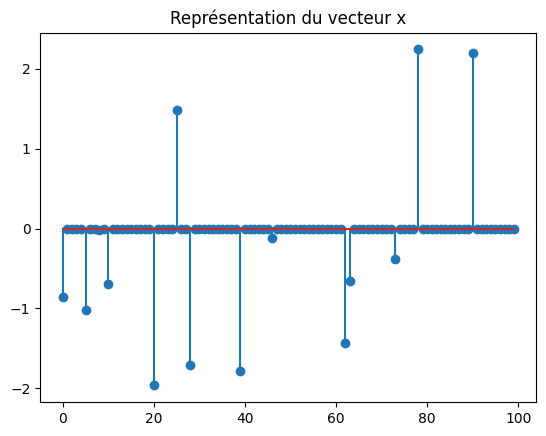

In [4]:
plt.stem(x)
titre = 'Représentation du vecteur x'
plt.title(titre)

## Construction of measurements matrices
We now want to construct potential random matrices. They will be based on powers of normal random variables.  

Constructed a matrix using powers of Gaussian random variables: that is the measurement matrix $A$ is populated with i.i.d. random variables like $${\rm sign}(g) |g|^p$$ where $g$ is a standard Gaussian variable and $p\geq1$ is some power.


In [5]:
def measurement_matrix(m, N, power = 2):
    """Construct a random matrix of size (m, N) for various type of random entries"""
    mat = np.random.randn(m,N)
    return np.multiply(mat**power, np.sign(mat))


In [6]:
A = measurement_matrix(2, 10)#, power = 4)
A

array([[-3.29353888e+00,  1.08364186e+00, -1.43171191e-01,
        -9.66727110e-01, -4.07456701e-02,  1.42126581e-01,
         8.56133130e-01, -2.80327940e+00, -6.53494534e-02,
         4.21998068e-01],
       [-3.07387017e-04, -9.22196796e-01, -4.52087908e-02,
         1.12005249e+00,  2.75485027e+00,  2.37208589e+00,
        -5.26926594e-02,  6.50686844e-01,  5.31446464e-03,
         4.92494204e-01]])

## Basis Pursuit as a linear program
One can recast the Basis Pursuit procedure as a linear program. 

Let $A\in\R^{m\times N}$ be a measurements matrix and $y\in\R^m$ be a measurements vector. We consider the following linear programming problem (LP):


> $$\min_{z^+,z^-\in\bR^N} \sum_{j=1}^n z_i^+ + z_i^-$$

> subject to $$ [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$



For any $x\in\R^N$, we denote by  $x^+\in\R^N$ and $x^-\in\R^N$ vectors with coordinates given for any $j=1,\ldots,N$ by 

\begin{equation*}
(x^+)_j = \max(0,x_j) \mbox{ et } (x^-)_j = \max(0,-x_j).
\end{equation*}

There is equivalence between the Basis Pursuit procedure and (LP) in the following way: 

>	If $\hat x$ is a solution to (BP) then $(\hat x^+, \hat x^-)$ is solution to (LP)

>	If $(\hat z^+, \hat z^-)$ is a solution to (LP) then $\hat z^+-\hat z^-$ is solution to (BP).




# Import cvxopt library for solving linear programming problems

**CVXOPT** is a very powerfull library for solving various type of convex optimization problems. We refer to examples from <a href="http://cvxopt.org/userguide/solvers.html#problems-with-nonlinear-objectives">Non-linear convex optimization</a> and <a href="http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td1a_cenonce_session9.html"> Xavier's TD9 </a>.

*solvers.cp* solves non-linear convex optimization problems with twices differentiable objective and constraint functions with closed form solutions for the gradient and the Hessian.

Here we are concerned about Linear Programming -- that is for convex optimization problems where both the objective and the constraints are linear.

In [7]:
from cvxopt import matrix, solvers, sparse, spmatrix, spdiag
solvers.options['show_progress'] = False # No logs printed

### matrix objects in cvxopt
cvxopt has its own *matrix* object which is different from the numpy's one

In [8]:
A = matrix([[1,2,3],[4,5,6]])
print(A, '-'*10, '\n',  A[1,:], '-'*10, '\n', A[::-1,::-1], '-'*10, '\n', A[0:4])
print('-'*10, '\n', A.size)

[ 1  4]
[ 2  5]
[ 3  6]
 ---------- 
 [ 2  5]
 ---------- 
 [ 6  3]
[ 5  2]
[ 4  1]
 ---------- 
 [ 1]
[ 2]
[ 3]
[ 4]

---------- 
 (3, 2)


In [9]:
A = matrix([1, 2, 3, 4, 5, 6], (2,3))
B = matrix([ [1, 2], [3, 4] ])
C = matrix([ [A] ,[B], [-A]])
D = matrix(range(16),(4,4))
E = matrix(np.ones(5))
F = matrix(np.random.randn(2,3))
G = matrix(np.zeros(2))
print(A,'-'*10, '\n', B, '-'*10, '\n', C, '-'*10, '\n', D, '-'*10, '\n', E, '-'*10, '\n', F, '-'*10, '\n', G)

[ 1  3  5]
[ 2  4  6]
 ---------- 
 [ 1  3]
[ 2  4]
 ---------- 
 [ 1  3  5  1  3 -1 -3 ... ]
[ 2  4  6  2  4 -2 -4 ... ]
 ---------- 
 [  0   4   8  12]
[  1   5   9  13]
[  2   6  10  14]
[  3   7  11  15]
 ---------- 
 [ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
 ---------- 
 [-2.33e-01 -6.63e-02 -8.51e-01]
[-1.64e+00 -6.19e-01 -7.57e-02]
 ---------- 
 [ 0.00e+00]
[ 0.00e+00]



In [10]:
A = matrix([[1,2,3],[4,5,6]])
B = np.array(A)
print(A, '-'*10, '\n', B)

[ 1  4]
[ 2  5]
[ 3  6]
 ---------- 
 [[1 4]
 [2 5]
 [3 6]]


### sparse matrix objects
cvxopti has its own *sparse matrix* object which is different from the scipy's one

In [11]:
E = spmatrix([1, 2], [0, 1], [0, 1], (4,2)) #(value, row, column)
B = matrix([ [1, 2], [3, 4] ])
F = sparse([ [B, B], [E] ])
G = spdiag([B, -B, 1, 2])
H = spdiag([1]*2)
K = matrix([B, -B])
K2 = matrix([[B], [-B]])
J = matrix([[B,-B, -H],[-B, B, -H]])
print(E, '-'*30, '\n', F, '-'*30, '\n', G, '-'*30, '\n', H)
print(K, '-'*30, '\n', K2, '-'*30, '\n', J)

[ 1.00e+00     0    ]
[    0      2.00e+00]
[    0         0    ]
[    0         0    ]
 ------------------------------ 
 [ 1.00e+00  3.00e+00  1.00e+00     0    ]
[ 2.00e+00  4.00e+00     0      2.00e+00]
[ 1.00e+00  3.00e+00     0         0    ]
[ 2.00e+00  4.00e+00     0         0    ]
 ------------------------------ 
 [ 1.00e+00  3.00e+00     0         0         0         0    ]
[ 2.00e+00  4.00e+00     0         0         0         0    ]
[    0         0     -1.00e+00 -3.00e+00     0         0    ]
[    0         0     -2.00e+00 -4.00e+00     0         0    ]
[    0         0         0         0      1.00e+00     0    ]
[    0         0         0         0         0      2.00e+00]
 ------------------------------ 
 [ 1.00e+00     0    ]
[    0      1.00e+00]

[ 1  3]
[ 2  4]
[-1 -3]
[-2 -4]
 ------------------------------ 
 [ 1  3 -1 -3]
[ 2  4 -2 -4]
 ------------------------------ 
 [ 1.00e+00  3.00e+00 -1.00e+00 -3.00e+00]
[ 2.00e+00  4.00e+00 -2.00e+00 -4.00e+00]
[-1.00e+00 -3

## Linear programming in cvxopt (cf. <a href = 'http://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.conelp'> cvxopt conelp solver </a> and <a href = 'http://cvxopt.org/userguide/coneprog.html#linear-programming'> cvxopt lp solver </a>)
Linear Programming problems in *cvxopt* have the following form
$$\min \inr{c,x} \mbox{ subject to } Gx + s =h, Ax=b, s\geq 0$$

CVXOPT command to solve this problem is 

> sol = cvxopt.solvers.lp(c, G, h[, A, b[, solver[, primalstart[, dualstart]]]])

> sol = sol['x']

The **solver** argument is used to choose among three solvers. When it is omitted or None, the CVXOPT function **conelp** is used. The external solvers **GLPK** and **MOSEK** (if installed) can be selected by setting solver to 'glpk' or 'mosek'.

Using option 'glpk' speeds up cvxopt by a factor of $2$ or $10$ (cf.  <a href = 'https://scaron.info/blog/linear-programming-in-python-with-cvxopt.html'> Stéphane Caron's webpage </a>)


# Solving (BP) via cvxopt

Let $A\in\bR^{m\times N}$ and $y\in\R^m$. (LP) is defined by:

> $$(\hat z^+, \hat z^-)\in\argmin_{(z^+,z^-)\in\bR^{2N}} \sum_{j=1}^n z_i^+ + z_i^-  \mbox{ subject to } [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right] = y \mbox{ and } \left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0 $$

Solution to (BP) is recovered via $t= \hat z^+- \hat z^-$.

Linear Programming problem considered in cvxopt have the following form: 


$$\min \inr{c,x} \mbox{ subject to } Gx + s =h, Ax=b, s\geq 0.$$

In the case of (LP) :

$$c = \left[\begin{array}{c} \1 \\ \1 \end{array}\right]\in\R^{2N};\hspace{1cm} G=-I_{2N}; \hspace{1cm} h = 0\in\R^{2N}; \hspace{1cm} A = [A|-A]\in\R^{m\times 2N};\hspace{1cm} b = y\in\R^m$$

### construction of cvxopt matrices $c, G, h, A, b$

In [12]:
measurement_matrix(2,10).shape

(2, 10)

In [13]:
def cvx_mat(A, y):
    '''A, y: numpy array or cvx matrices
    return parameters c, G, h, A, b for CVXOPT solvers.lp method'''
    m, N = A.shape
    c= matrix(np.ones(2*N))
    G = spdiag([-1]*(2*N))
    h = matrix(np.zeros(2*N))
    A_cvx = matrix([[matrix(A)], [matrix(-A)]])
    b = matrix(y)
    return c, G, h, A_cvx, b

In [14]:
N, m, s = 1000, 50, 3
A, x = measurement_matrix(m, N), signal(N, s) 
y = np.dot(A,x)
c, G, h, A, b = cvx_mat(A, y)
#print(c, '-'*10, '\n', G,'-'*10, '\n', h,'-'*10, '\n', A,'-'*10, '\n', b)

### cvxopt linear solver  <a href="http://cvxopt.org/examples/tutorial/lp.html"> cvx lp </a>

In [15]:
sol = solvers.lp(c, G, h, A, b)#, solver = 'glpk')
sol = sol['x']
x_recover = sol[0:N] - sol[N:2*N]

In [16]:
np.linalg.norm(matrix(x) - x_recover,2)

1.2006328422377867e-08

In [17]:
def dist(x, sol):
    N = len(x)
    x_recover = sol[0:N] - sol[N:2*N]
    return np.linalg.norm(matrix(x) - x_recover,2)

In [18]:
N, m, s = 500, 80, 10
A, x = measurement_matrix(m, N), signal(N, s) 
y = np.dot(A,x)
c, G, h, A, b = cvx_mat(A, y)
sol = solvers.lp(c, G, h, A, b)
sol = sol['x']
x_recover = sol[0:N] - sol[N:2*N]
print('erreur ell_2 = {}'.format(dist(x, sol)))

erreur ell_2 = 1.2814812878354894e-08


Text(0.5, 1.0, 'reconstruction')

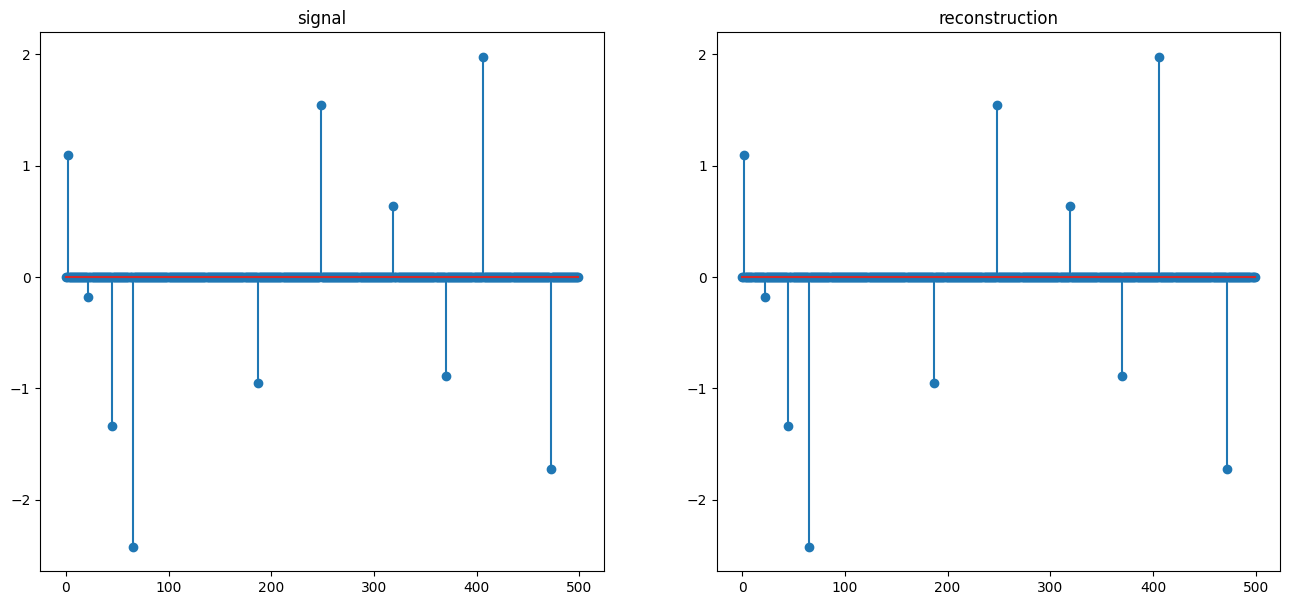

In [19]:
fig, (subfig1,subfig2) = plt.subplots(1,2,figsize=(16,7)) # one figure with two horizontal subfigures
subfig1.stem(x)
subfig1.set_title('signal')
subfig2.stem(x_recover)
subfig2.set_title('reconstruction')

# Phase transition diagrams for (BP)

We say that the reconstruction is a success when $||x-x_{recover}||_2\leq 0.001$

In [20]:
def phase_transition_mat(N, nbtest, success = 1e-3, power = 2):
    """return a N.N/2 matrix with the number of reconstruction success for every  1\leq m \leq N measurements 
    and sparsity 1\leq sparsity \leq N/2
    N : ambiant dimension of the signals
    nbtest : number of tests for each pixel"""
    PTM = np.zeros([N, N // 2 + 1])
    
    for cur_m in range(1,N+1): 
        for cur_s in range(1,min(N//2+1,m)): 
            for a_test in range(nbtest): 
                # Generate a random matrix
                A = measurement_matrix(cur_m, N, power)
                # Generate a random vector 
                x0 = signal(N,cur_s)
                # Recover through cvx opt as before 
                y = np.dot(A,x0)
                c,G,h,Acvx,b = cvx_mat(A,y)
                sol = solvers.lp(c, G, h, Acvx, b)
                sol = sol['x']
                x_recover = sol[0:N] - sol[N:2*N]
                # Add one if error is smaller than the given threshold
                cur_accuracy = dist(x0, sol)
                PTM[cur_m-1,cur_s-1] += cur_accuracy < success
    return PTM

In [21]:
def frontier(mat, nbtest):
    """construction of the phase transition frontier, i.e. first time the number of success goes below nbtest/2"""
    L = []
    N = len(mat)
    for s in range(int(N/2)):
        P = 0
        while mat[P,s]<nbtest/2 and P<N-1:
            P = P + 1
        L.append(P)
    return L

In [22]:
N, nbtest = 50, 16
mat = phase_transition_mat(N, nbtest)# construction of the matrix with the number of success among nbtest

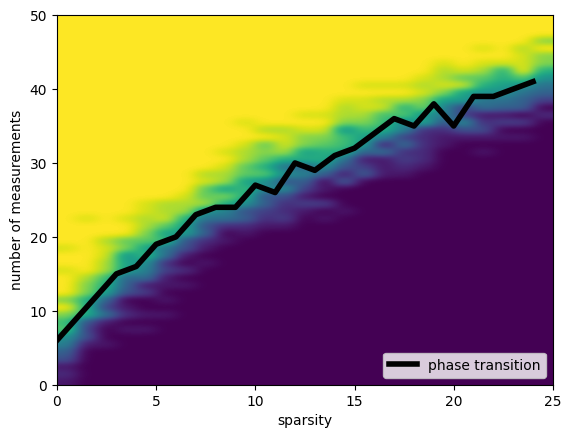

In [23]:
P_min, P_max, S_min, S_max = 0, N, 0, int(N/2)
fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                 aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
plt.xlabel('sparsity')
plt.ylabel('number of measurements')

#empirical phase transition
X = range(int(N/2))
L = frontier(mat, nbtest)
plt.plot(X,L, linewidth=4, color = 'black', label='phase transition')
plt.legend(loc=4)

#filename = 'noisy_gaussian_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

We are now ready to compare the results of the basis pursuit with other algorithms. 

we first implement the Orthogonal Matching Pursuit, and then go on to Hard Thresholding approaches (Iterative Hard Thresholding and then Hard Thresholding Pursuit)

We refer to the lecture notes for the definitions of the algorithms. 

TODO: 

Implement 
* OMP
* IHT 
* HTP 
* Adapt the phase transition function to take into account the new algorithms (you may add a parameter which would be a function handle to the appropriate recovery algorithm)

TODO: Compare the results with other powers applied to the _Gaussian_ measurement matrix.